✅ Dataset Loaded Successfully!
Shape: (891, 12)
✅ Model trained successfully!

📊 Model Evaluation:
Accuracy: 0.8101
ROC AUC: 0.8519

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



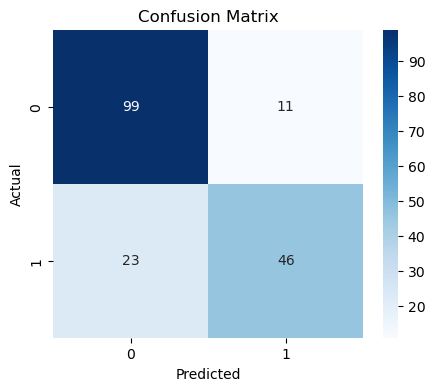

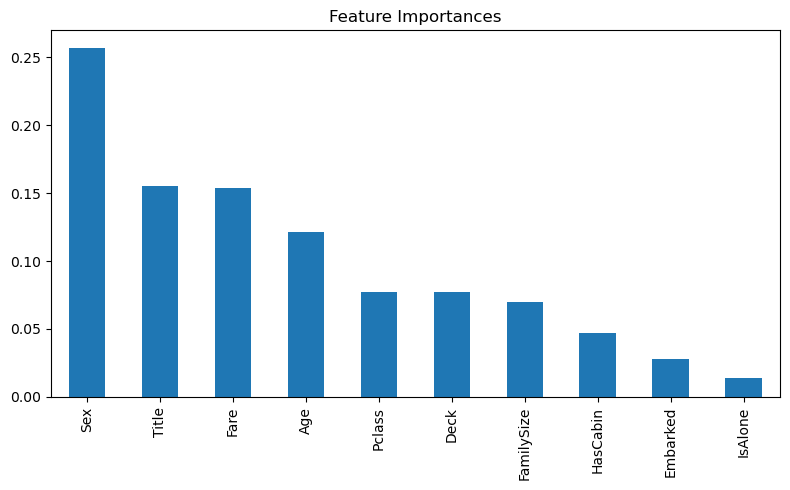


🧍 Sample Passenger Prediction:
Survived: 1  (Probability: 0.72)

💾 Model saved as titanic_model.joblib


In [2]:
! pip install pandas numpy scikit-learn matplotlib joblib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import joblib

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)

def extract_title(name):
    if pd.isnull(name):
        return "Rare"
    title = name.split(',')[1].split('.')[0].strip()
    return title

data = df.copy()
data['Title'] = data['Name'].apply(extract_title)
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Countess': 'Rare', 'Lady': 'Rare', 'Sir': 'Rare',
    'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare',
    'Capt': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 'Rev': 'Rare'
}
data['Title'] = data['Title'].replace(title_map)
rare_titles = data['Title'].value_counts()[data['Title'].value_counts() < 10].index
data['Title'] = data['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
data['HasCabin'] = data['Cabin'].notnull().astype(int)
data['Deck'] = data['Cabin'].fillna('N').apply(lambda x: x[0])
data['Age'] = data['Age'].fillna(data.groupby('Title')['Age'].transform('median'))
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'HasCabin', 'Deck']
X = data[features].copy()
y = data['Survived']

le = LabelEncoder()
for col in ['Sex', 'Embarked', 'Title', 'Deck']:
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("✅ Model trained successfully!")

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n📊 Model Evaluation:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importances.plot(kind='bar')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

sample = {
    'Pclass': 3, 'Sex': 'male', 'Age': 22, 'Fare': 7.25, 'Embarked': 'S',
    'Title': 'Mr', 'FamilySize': 2, 'IsAlone': 0, 'HasCabin': 0, 'Deck': 'N'
}
sample_df = pd.DataFrame([sample])
for col in ['Sex', 'Embarked', 'Title', 'Deck']:
    sample_df[col] = le.fit_transform(sample_df[col])

pred = model.predict(sample_df)[0]
prob = model.predict_proba(sample_df)[0, 1]
print("\n🧍 Sample Passenger Prediction:")
print(f"Survived: {pred}  (Probability: {prob:.2f})")

joblib.dump(model, "titanic_model.joblib")
print("\n💾 Model saved as titanic_model.joblib")
